In [73]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import math
import os

# temporal resolution of the features
RESOLUTION = 0.12
  
# load the metadata
metadata_df = pd.read_csv("dataset/metadata.csv")
title_embeddings = np.load("dataset/metadata_title_embeddings.npz")["embeddings"]
keywords_embeddings = np.load("dataset/metadata_keywords_embeddings.npz")["embeddings"]
  
# load the annotations
annotations_df = pd.read_csv("dataset/annotations.csv")
annotations_embeddings = np.load("dataset/annotations_text_embeddings.npz")["embeddings"]
  
# load audio features
feature_filename = metadata_df.loc[0, "filename"].replace("mp3", "npz")
features = np.load(os.path.join("dataset/audio_features", feature_filename))
print(list(features.keys()))
print("Shape of ZCR feature (time, n_features)", features["zerocrossingrate"].shape)
print("Shape of MFCC features (time, n_features)", features["mfcc"].shape)
  
# load audio (optional, just i you want to compute your own features ...)
import librosa
waveform, sr = librosa.load(os.path.join("dataset/audio", metadata_df.loc[0, "filename"]), sr=16000)

['embeddings', 'melspectrogram', 'mfcc', 'mfcc_delta', 'mfcc_delta2', 'flatness', 'centroid', 'flux', 'energy', 'power', 'bandwidth', 'contrast', 'zerocrossingrate']
Shape of ZCR feature (time, n_features) (233, 1)
Shape of MFCC features (time, n_features) (233, 32)


## 1. Case Stuy
Find two interesting recordings with at least two annotators and multiple annotations.
Compare the temporal and textual annotations, and try to answer the following questions:

(a) Identify similarities or differences between temporal and textual annotations from different annotators.<br>
(b) To what extent do the annotations rely on or deviate from keywords and textual descriptions in the
audio’s metadata?<br>
(c) Was the temporal and text annotations done according to the task description?


      filename  n_annotators
16  102744.mp3             2
74  110921.mp3             2


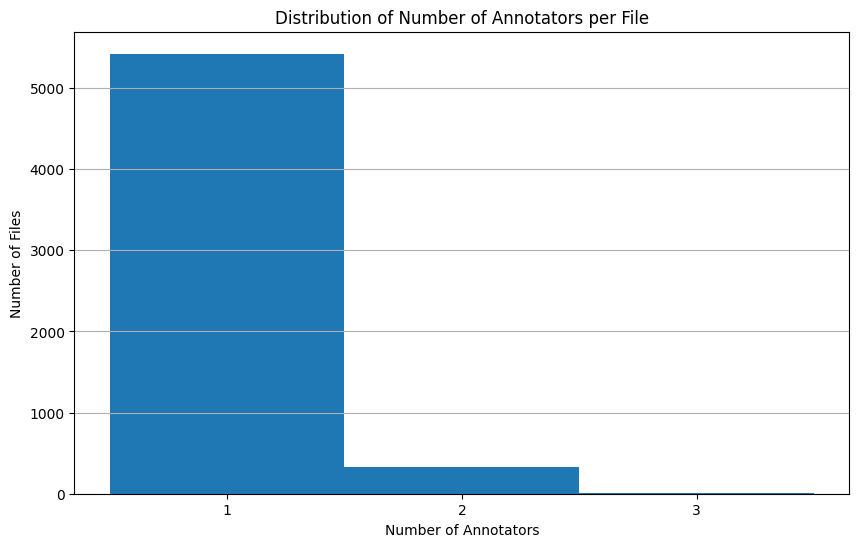

In [74]:
# group annotations by filename and annotator
grouped = annotations_df.groupby(['filename', 'annotator']).size().reset_index(name='annot_count')

# filter for files with at least 2 annotations
filtered = grouped[grouped['annot_count'] >= 2]

# filter for files with at least 2 unique annotators
annot_per_file = filtered.groupby('filename')['annotator'].nunique().reset_index(name='n_annotators')
need_files = annot_per_file[annot_per_file['n_annotators'] >= 2]
print(need_files[:2])

# plot histogram of number of annotators per file
plt.figure(figsize=(10, 6))
plt.hist(annot_per_file['n_annotators'], bins=range(1, annot_per_file['n_annotators'].max() + 2), align='left')
plt.xticks(range(1, need_files['n_annotators'].max() + 1))
plt.xlabel('Number of Annotators')
plt.ylabel('Number of Files')
plt.title('Distribution of Number of Annotators per File')
plt.grid(axis='y')
plt.savefig("annotators_per_file.png", dpi=300, bbox_inches='tight')
plt.show()


## 2. Annotation Quality
Use the audio recordings annotated by multiple annotators to answer the following questions:

(a) How precise are the temporal annotations?<br>
(b) How similar are the text annotations that correspond to the same region?

Use the complete data set (or a subset) to address the following points quantitatively.

(a) How many annotations did we collect per file? How many distinct sound events per file?<br>
(b) How detailed are the text annotations? How much does the quality of annotations vary between different annotators? <br>
(c) Are there any obvious inconsistencies, outliers, or poor-quality annotations in the data?<br>
Propose a simple method to filter or fix incorrect or poor-quality annotations (e.g., remove outliers, typos, or spelling errors).

In [75]:
annotations_file = annotations_df.groupby('filename').size().reset_index(name='n_annotations')

# get number of annotations per file
num_annotations = annotations_file['n_annotations']
print(f"Number of annotations per file: {num_annotations.min():.2f} - {num_annotations.mean():.2f} - {num_annotations.max():.2f}")

# get number of unique annotators per file
num_annotators = annot_per_file['n_annotators']
print(f"Number of unique annotators per file: {num_annotators.min():.2f} - {num_annotators.mean():.2f} - {num_annotators.max():.2f}")

# get number of words per annotation
num_words = annotations_df['text'].str.split().str.len()
print(f"Number of words per annotation: {num_words.min():.2f} - {num_words.mean():.2f} - {num_words.max():.2f}")

Number of annotations per file: 1.00 - 3.97 - 96.00
Number of unique annotators per file: 1.00 - 1.06 - 3.00
Number of words per annotation: 1.00 - 7.49 - 88.00


In [76]:
# top 10 files with most annotations
annots_sorted = annotations_file.sort_values(by='n_annotations', ascending=False)
print("\nTop 10 files with most annotations:")
print(annots_sorted.head(10))


Top 10 files with most annotations:
        filename  n_annotations
6578  623187.mp3             96
8926   94017.mp3             73
6250  591203.mp3             65
5264  518570.mp3             63
6537  620967.mp3             42
3541  406538.mp3             40
8630  777608.mp3             40
2795  352225.mp3             39
2126  272516.mp3             38
3526  406166.mp3             38


In [77]:
# top 10 files with most unique annotators
annot_sorted = annot_per_file.sort_values(by='n_annotators', ascending=False)
print("\nTop 10 files with most unique annotators:")
print(annot_sorted.head(10))


Top 10 files with most unique annotators:
        filename  n_annotators
2259  407115.mp3             3
1740  352781.mp3             3
3861  582364.mp3             3
1000   22909.mp3             2
5450  766274.mp3             2
5127  723573.mp3             2
2023  388423.mp3             2
2659  448133.mp3             2
1287  267146.mp3             2
4533  654135.mp3             2


In [78]:
# top 10 annotators with most annotations
annotator_sorted = annotations_df['annotator'].value_counts().reset_index()
annotator_sorted.columns = ['annotator', 'n_annotations']
print("\nTop 10 annotators with most annotations:")
print(annotator_sorted.head(10))

print(annotator_sorted.tail(10))


Top 10 annotators with most annotations:
                                           annotator  n_annotations
0  7730311164966960713783008629945271263745821651...            376
1  7762469365514054983406129319740213590901926202...            305
2  8060585732629273722076290004201782786412117139...            244
3  7976070832766821125170150784043122830962235999...            239
4  1148945642320935652880229597605752757235655545...            239
5  7677568323544261764859631231436542107544499365...            227
6  1069118861661576065523943476680829194149476935...            227
7  4901733987244060510400597246219604505934613039...            223
8  4566938478667233132561687727447724818515641890...            221
9  5641336252552682904222411129418002005581708993...            215
                                             annotator  n_annotations
320  6935232860871384231974849930538530293809729830...             35
321  7572826884825472478962447952760999682134804728...             35


## 3. Audio Features 
Load and analyze the audio features:

(a) Which audio features appear useful? Select only the most relevant ones or perform a down projection for the next steps. <br>
(b) Extract a fixed-length feature vector for each annotated region as well as for all the silent parts in between. The most straightforward way to do this is to average the audio features of the corresponding
region over time, as shown in the tutorial session. <br>
(c) Cluster the audio features for the extracted regions. Can you identify meaningful clusters of audio
features? Do the feature vectors of the silent regions predominantly fall into one large cluster?<br>

In [79]:
audio_features = {}

# make sure filename is the new index for metadata_df
_metadata = metadata_df.set_index("filename")

for idx, row in _metadata.iterrows():
    file_name = idx.replace("mp3", "npz")
    path_features = os.path.join("dataset/audio_features", file_name)
    features = np.load(path_features)["embeddings"]
    audio_features[idx] = features
    
print("Number of feature files: ", len(audio_features))

Number of feature files:  9026


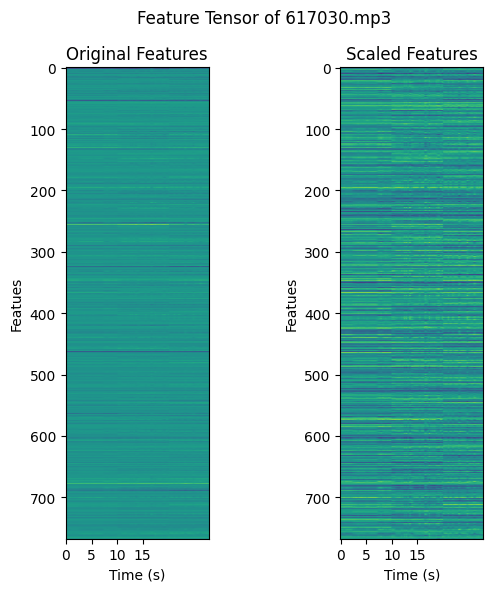

In [80]:
concatenated_feature_tensor = np.concatenate(list(audio_features.values()), axis=0)
scaler = StandardScaler().fit(concatenated_feature_tensor)

feature_tensor = audio_features[_metadata.index[0]]

fig, ax = plt.subplots(1, 2, figsize=(6, 6))
fig.suptitle(f"Feature Tensor of {_metadata.index[0]}")

ax[0].imshow(feature_tensor.T)
ax[0].set_xticks(np.arange(0,20,5) / RESOLUTION, np.arange(0,20,5))
ax[0].set_title("Original Features")
ax[0].set_xlabel("Time (s)")
ax[0].set_ylabel("Featues")

ax[1].imshow(scaler.transform(feature_tensor).T)
ax[1].set_xticks(np.arange(0,20,5) / RESOLUTION, np.arange(0,20,5))
ax[1].set_title("Scaled Features")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Featues")

plt.tight_layout()
plt.savefig("feature_tensor.png", dpi=300, bbox_inches='tight')
plt.show()  

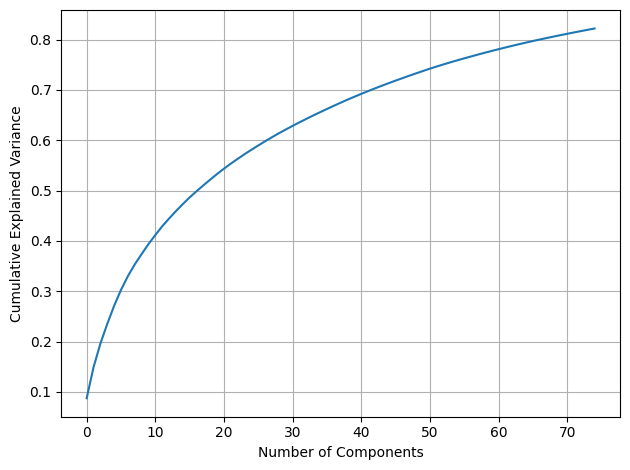

In [ ]:
# Fit PCA on all standardized features
pca = PCA(n_components=75)
pca.fit(scaler.transform(concatenated_feature_tensor))

# visualize explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.savefig("pca_explained_variance.png", dpi=300, bbox_inches='tight')
plt.show()

In [82]:
# merge annotations and metadata
merged_df = annotations_df.merge(_metadata, on="filename", how="left", suffixes=("", "_metadata"))
_len = len(merged_df)

# add silent regions between annotations
merged_incl_silent = merged_df.copy()
for filename, features in audio_features.items():
    annotations = merged_incl_silent[merged_incl_silent["filename"] == filename].sort_values("onset")
    last_end = 0
    for _, row in annotations.iterrows():
        start_frame = math.floor(row['onset'] / RESOLUTION)
        end_frame = math.ceil(row['offset'] / RESOLUTION)        
        
        # silent region between annotations
        if start_frame > last_end:
            # append silent region to merged_df
            merged_incl_silent.loc[len(merged_incl_silent)] = {"onset": last_end * RESOLUTION, "offset": start_frame * RESOLUTION, "filename": filename, "annotator": row["annotator"], "text": ""}

        if last_end < end_frame:
            last_end = end_frame
        
print(len(merged_incl_silent) - _len, "silent regions added")

7777 silent regions added


In [83]:
def get_features_of_annotation(onset: float, offset: float, audio_features: np.ndarray, scaler: StandardScaler = None) -> np.ndarray:
    start = math.floor(onset / RESOLUTION)
    end = math.ceil(offset / RESOLUTION)
    audio_features = audio_features[start:end, :]
    if scaler is not None:
        audio_features = scaler.transform(audio_features)
    return audio_features.mean(axis=0)

X = np.zeros((len(merged_incl_silent), 768))
for i, row in merged_incl_silent.iterrows():
    X[i] = get_features_of_annotation(row['onset'], row['offset'], audio_features[row['filename']], scaler)

N_CLUSTERS = 25
kmeans = KMeans(n_init=10, n_clusters=N_CLUSTERS, max_iter=300, random_state=42).fit(X)
clusters_assignment = kmeans.predict(X)
merged_incl_silent['cluster_assignment'] = clusters_assignment

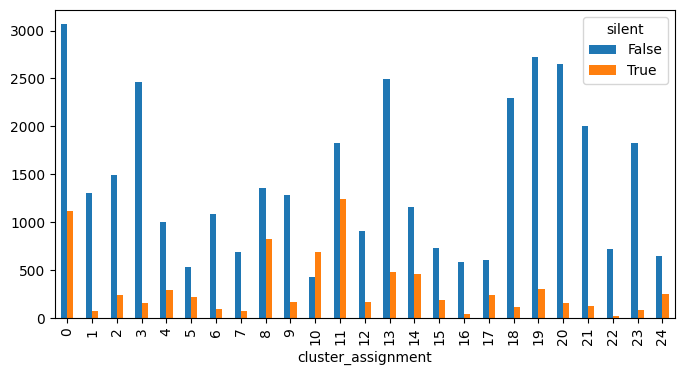

In [84]:
def is_silent(text_annotation):
    return text_annotation is None or text_annotation == ""

merged_incl_silent['silent'] = merged_incl_silent["text"].apply(is_silent)
merged_incl_silent.groupby(["cluster_assignment", "silent"]).size().unstack(fill_value=0).plot(kind="bar", figsize=(8, 4))
plt.savefig("silent_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# merged_incl_silent.to_csv("output.csv", index=False, sep=",", encoding="utf-8")

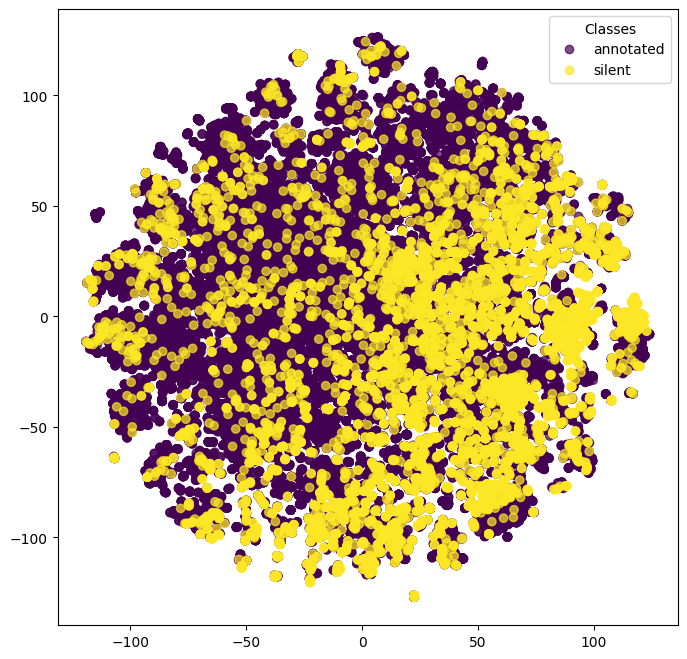

In [86]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

plt.figure(figsize=(8, 8))
scatter = plt.scatter(tsne[:, 0], tsne[:, 1], c=merged_incl_silent["silent"], alpha=0.7)
handles, _ = scatter.legend_elements()
plt.legend(handles, ['annotated', 'silent'], title="Classes")
plt.savefig("tsne_silent.png", dpi=300, bbox_inches='tight')
plt.show()

## 4. Text Features
Load and analyze the text features:

(a) Cluster the text features. Can you find meaningful clusters?<br>
(b) Design a labeling function1 for classes dog and cat. Do the annotations labeled as dog or cat sounds form tight clusters in the text and audio feature space?<br>
(c) How well do the audio feature clusters align with text clusters?

In [87]:
X = np.zeros((len(merged_df), 768))
for i, row in merged_df.iterrows():
    X[i] = get_features_of_annotation(row['onset'], row['offset'], audio_features[row['filename']], scaler)

N_CLUSTERS = 25
kmeans = KMeans(n_init=10, n_clusters=N_CLUSTERS, max_iter=300, random_state=42).fit(X)
clusters_assignment = kmeans.predict(X)
merged_df['cluster_assignment'] = clusters_assignment

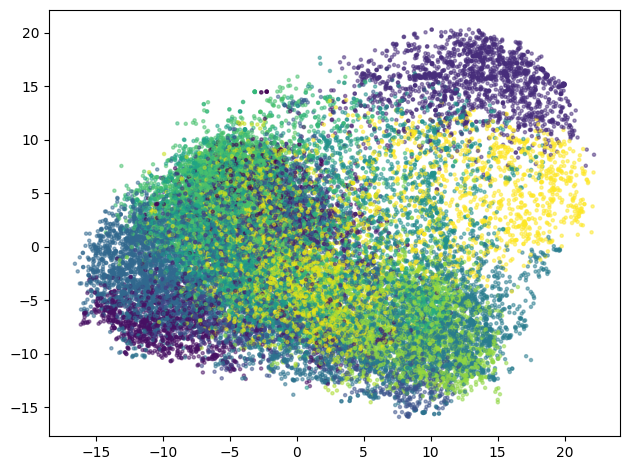

In [88]:
# Visualizing clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_assignment, s=5, alpha=0.5)
plt.tight_layout()
plt.savefig("pca_clusters.png", dpi=300)
plt.show()

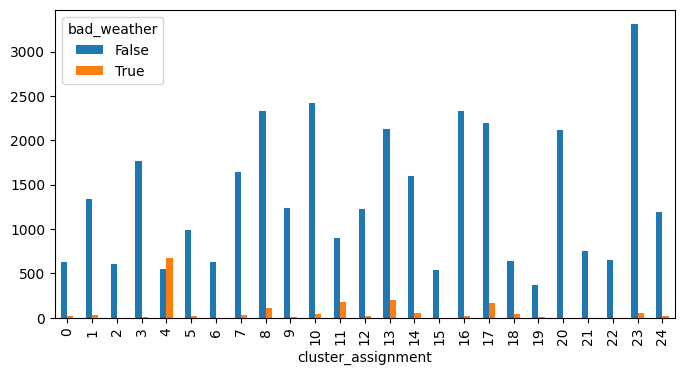

41            Rain constantly pouring on a car outdoors.
57                                         rain dripping
66                   The muffled sound of a gust of wind
82             Low sound of consistent and distant rain.
131    Raindrops softly hitting a tent, creating a ge...
176                               Ambient sound of rain.
188    Rain falls with background bird chirping in an...
216                                  wind softly blowing
224    An ambulance siren wails with a high-pitched, ...
226         A single raindrop or hail falling on a roof.
273                    Rain is falling in the background
299    A thunder striking fading with time and echoin...
309             laughter with a rumble in the background
372    Abrupt rumbling thunder in the distance during...
374    Very distant sound of thunder, echo, natural, ...
387    Rain taps against a muffled surface dully and ...
395    Faint distant thunder rumbling with sound degr...
402                            

In [89]:
def is_bad_weather(text_annotation):
    for token in text_annotation.split():
        if token.lower() in ["rain", "storm", "thunder", "lightning", "wind"]:
            return True
    return False

merged_df['bad_weather'] = merged_df["text"].apply(is_bad_weather)
merged_df.groupby(["cluster_assignment", "bad_weather"]).size().unstack(fill_value=0).plot(kind="bar", figsize=(8, 4))
plt.savefig("bad_weather_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

display(merged_df.loc[merged_df["cluster_assignment"].isin([4]), "text"].head(25))

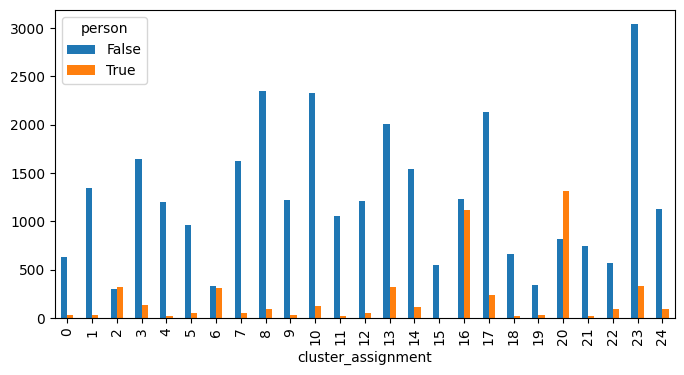

38      A person coughing in the background repeatedly. 
60                            A person blowing its nose.
64                         Audience laughing dying down.
92     A man saying: "Well I have to say, I am tired ...
96                 A man scaredly shouting "It's a gost"
109     a man talking with a high-pitched menacing voice
115    A girl sobbing rhythmically with short pauses ...
149             A dog growls with a low, rhythmic sound.
155                             A person coughing loudly
157             a child chuckling and laughing in bursts
159                               A short and a long hum
161    Male voice humming in the microphone sounding bad
173    Pig is snorting once with a quick sound while ...
180                           human cheering and yelling
182                       A man says ''oh'' in surprise.
205          somebody clering their throat indoor loudly
210    A low sound of a man's voice speaking loudly w...
212                          Ma

In [90]:
def is_person(text_annotation):
    for token in text_annotation.split():
        if token.lower() in ["people", "person", "man", "male", "woman", "female", "talking", "speaking", "voice", "conversation"]:
            return True
    return False

merged_df['person'] = merged_df["text"].apply(is_person)
merged_df.groupby(["cluster_assignment", "person"]).size().unstack(fill_value=0).plot(kind="bar", figsize=(8, 4))
plt.savefig("person_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

display(merged_df.loc[merged_df["cluster_assignment"].isin([20]), "text"].head(25))

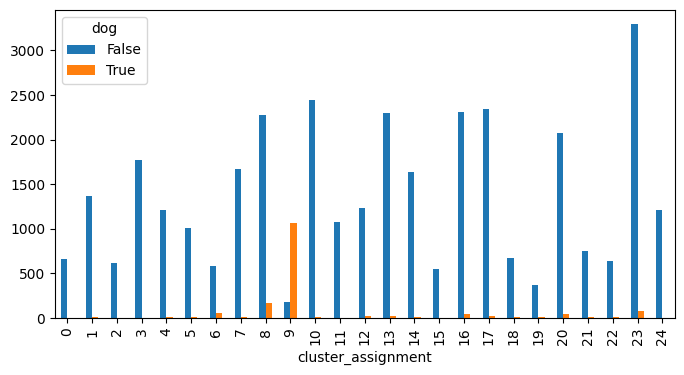

12                        A dog is barking furiously.
53               Dog barking loudly in the background
58                        A noise humming constantly.
62                                      A dog barking
93                                  a single dog bark
94                                       A dog growls
104            pigs growling loudly and aggressively.
110                                      dog barking 
129                                 Dog barking husky
211                                Very loud dog bark
250                               Dog barking loudly 
355        Two small dogs barking and whining softly.
356                         A dog barking repeatedly 
359               A dog barks quietly in the distance
364    Repeated distant dog barking from the outside 
375                              dogs barking outside
409                                  a dog is howling
559                                       single bark
580      A dog barking loudl

In [91]:
def is_dog(text_annotation):
    for token in text_annotation.split():
        if token.lower() in ["dog", "bark", "barking"]:
            return True
    return False

merged_df['dog'] = merged_df["text"].apply(is_dog)
merged_df.groupby(["cluster_assignment", "dog"]).size().unstack(fill_value=0).plot(kind="bar", figsize=(8, 4))
plt.savefig("dog_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

display(merged_df.loc[merged_df["cluster_assignment"].isin([9]), "text"].head(25))

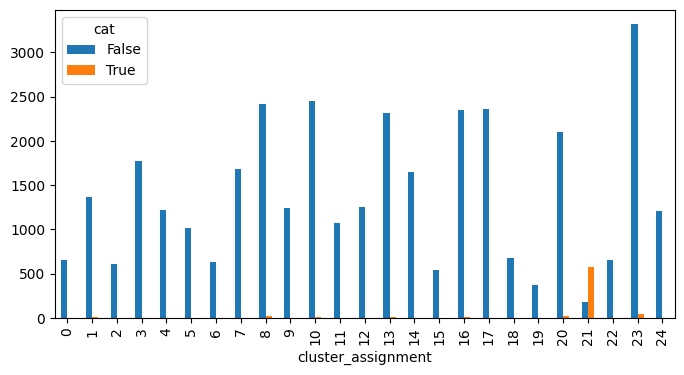

3                 A high pitch meowing coming from a cat
27     Continuous purrr like sound which resembles to...
63     opening or closing a zip noise in background, ...
107      Low-pitched cat meow with low background noise.
123       A ball kicking the ground one time, distantly.
147                              very weak meow of a cat
160                         small cat is worried meowing
164                                          Cat meowing
165                           a cat growl multiple times
177    wind noise, clear, low-pitched, intermittent, ...
184              A cat miaus briefly and loudly indoors.
198          An old clock on the wall is ticking softly.
289                                A cat meowing nearby.
311                         A cat purrs briefly indoors.
384                         A cat meowing softly indoors
389          Cat purrs indoors on mid-volume repeatedly.
487                        A soft purr coming from a cat
543    A ball kicking the groun

In [92]:
def is_cat(text_annotation):
    for token in text_annotation.split():
        if token.lower() in ["cat", "meow", "meowing"]:
            return True
    return False

merged_df['cat'] = merged_df["text"].apply(is_cat)
merged_df.groupby(["cluster_assignment", "cat"]).size().unstack(fill_value=0).plot(kind="bar", figsize=(8, 4))
plt.savefig("cat_clusters.png", dpi=300, bbox_inches='tight')
plt.show()

display(merged_df.loc[merged_df["cluster_assignment"].isin([21]), "text"].head(25))

Cluster 4 - bad_weather


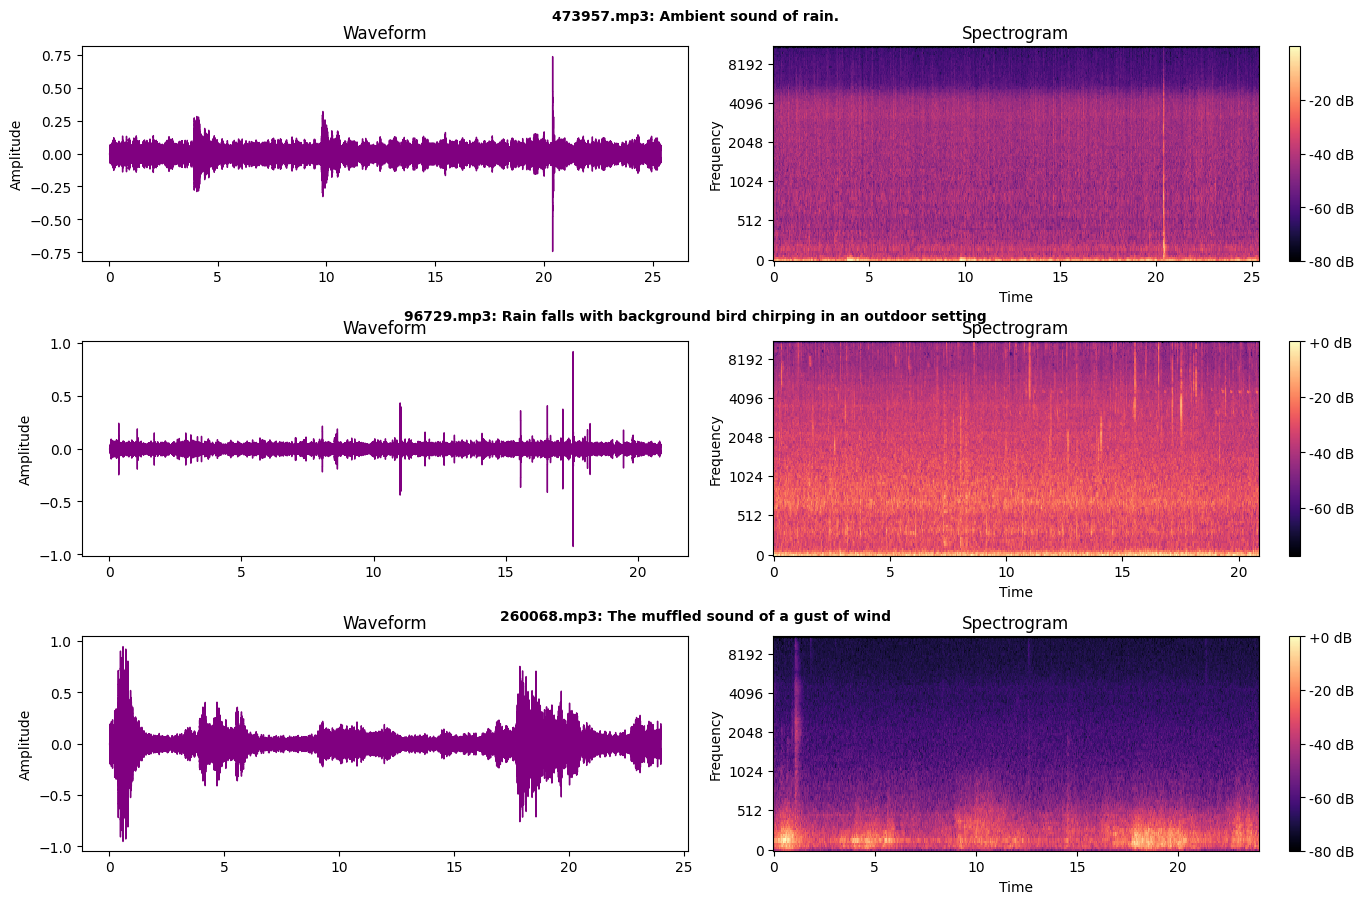

Cluster 20 - person


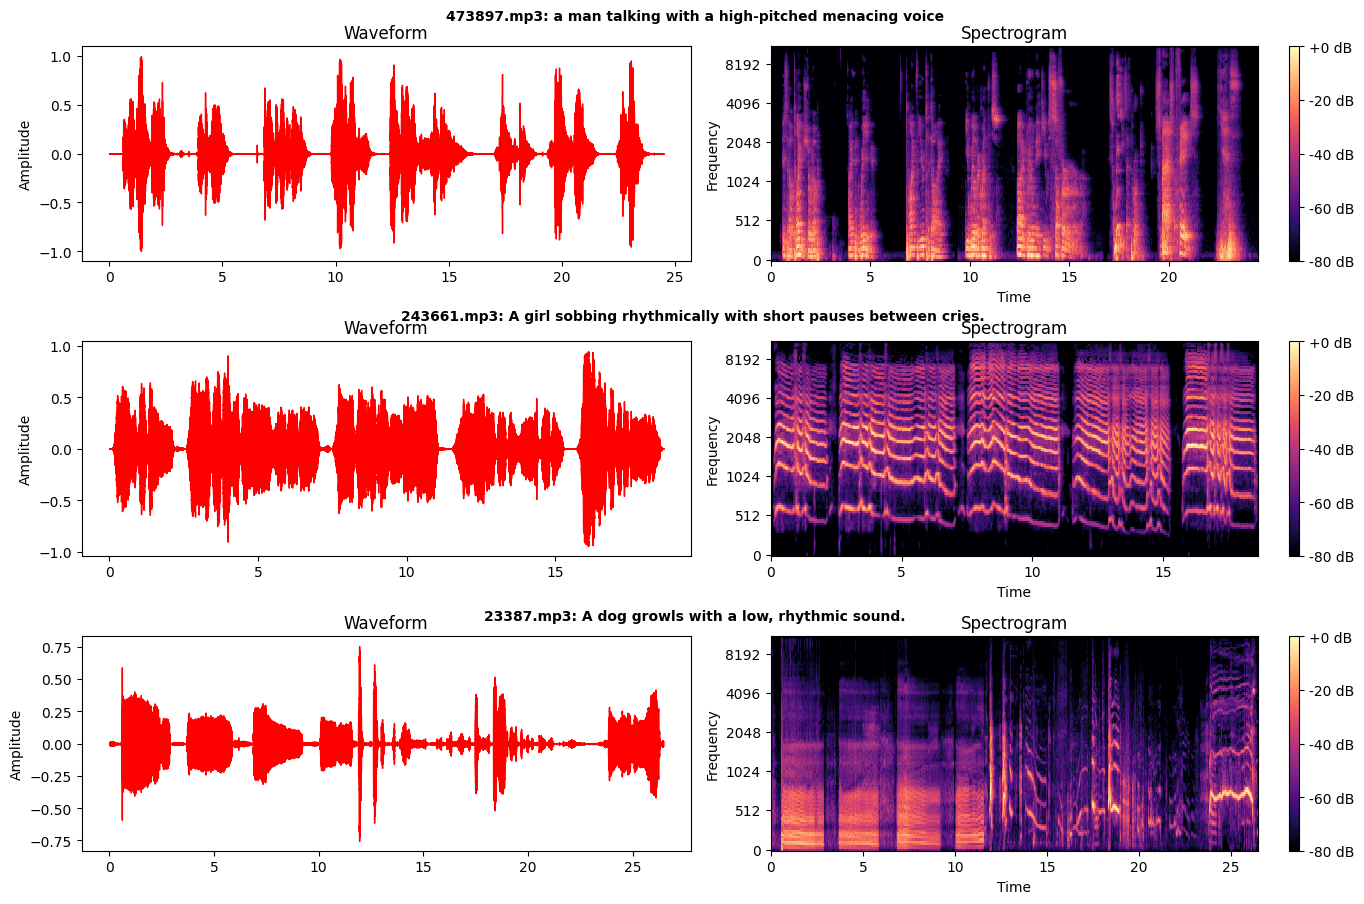

Cluster 9 - dog


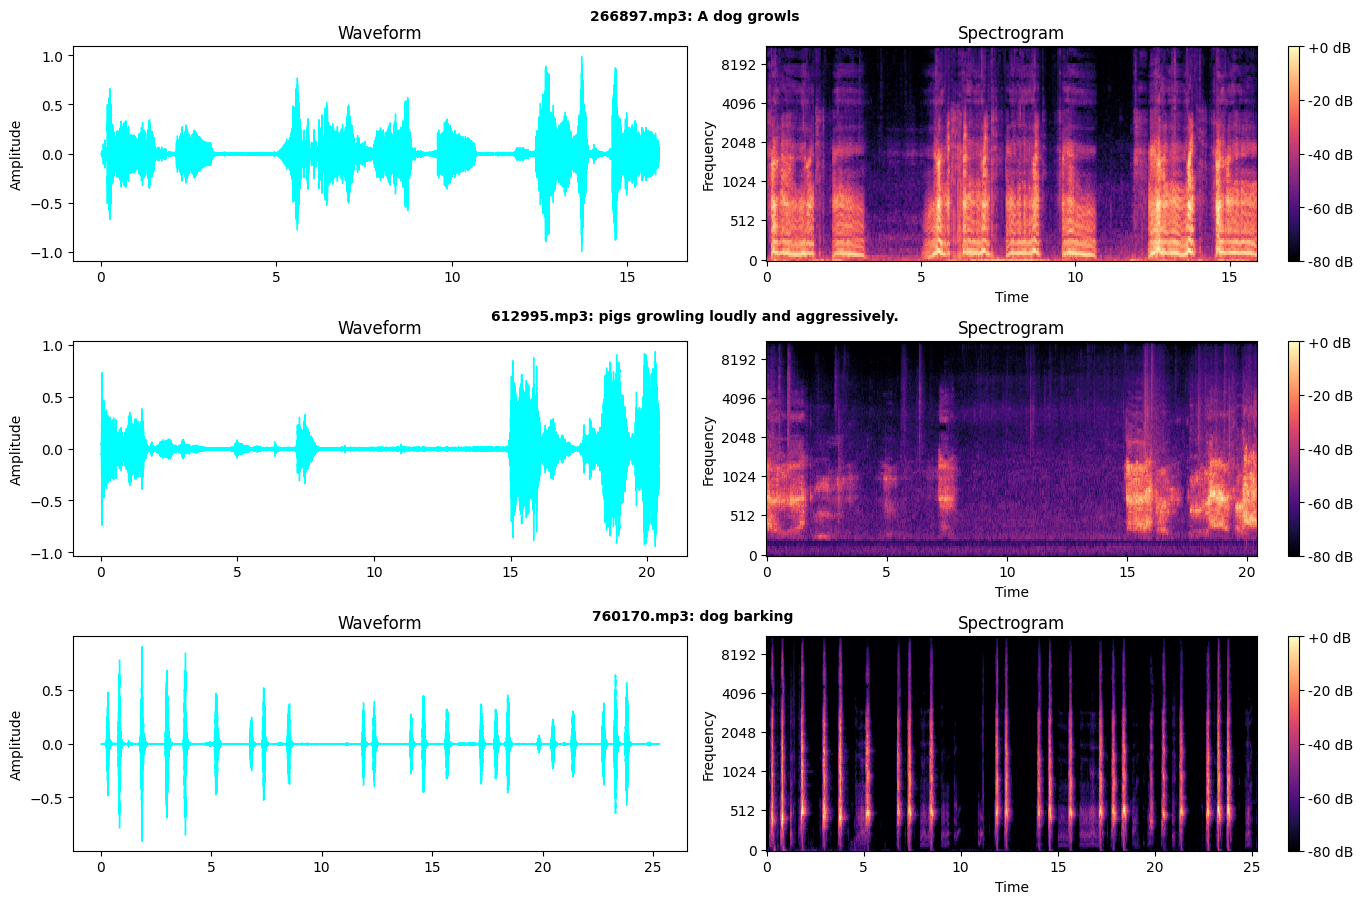

Cluster 21 - cat


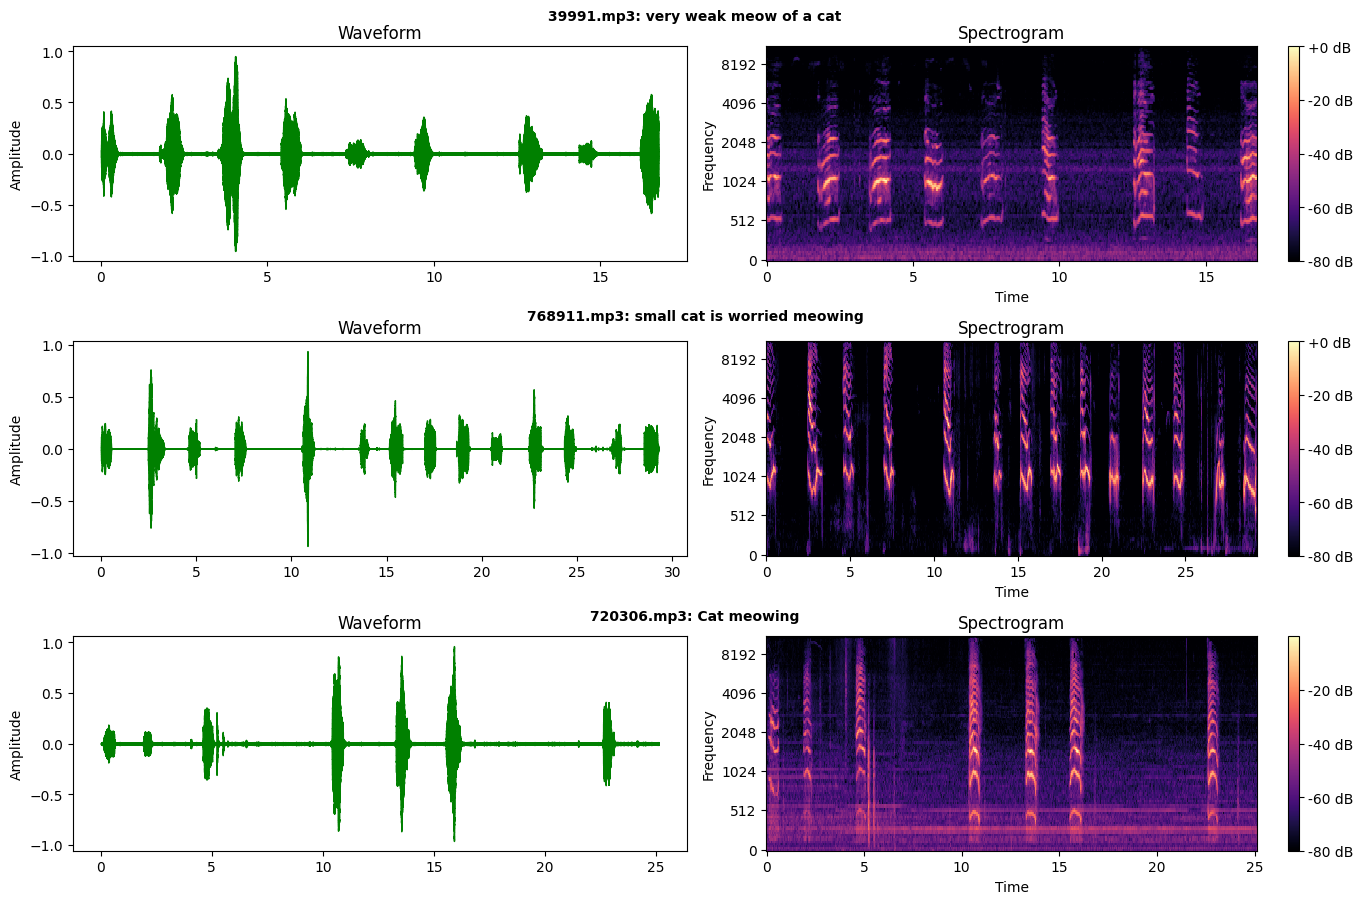

In [93]:
plot_colors = ["red", "green", "blue", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]
n_files_to_show = 3
file_offset = 5 # index from where on in the cluster to take the files to show

# identified clusters
identified_clusters = {"bad_weather": 4, "person": 20, "dog": 9, "cat": 21}


for key, i in identified_clusters.items():
    print(f"Cluster {i} - {key}")

    cluster_files = merged_df[merged_df["cluster_assignment"] == i]["filename"]
    fig, axes = plt.subplots(n_files_to_show, 2, figsize=(14, 3 * n_files_to_show))

    for j, file in enumerate(cluster_files[file_offset:n_files_to_show + file_offset].values):
        audio, sr = librosa.load(os.path.join("dataset/audio", file))
        ax_wave, ax_spec = axes[j] if n_files_to_show > 1 else axes

        # annoation as header
        annotation = merged_df[merged_df['filename'] == file]['text'].values[0]
        fig.text(0.5, 1 - j / n_files_to_show, f"{file}: {annotation}", ha="center", va="top", fontsize=10, fontweight="bold")

        # Plot waveform with cluster color
        librosa.display.waveshow(audio, sr=sr, ax=ax_wave, color=plot_colors[i % len(plot_colors)])
        ax_wave.set_title("Waveform")
        ax_wave.set_ylabel("Amplitude")
        ax_wave.set_xlabel("")

        # Compute and plot spectrogram
        S = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
        S_dB = librosa.power_to_db(S, ref=np.max)

        img = librosa.display.specshow(S_dB, sr=sr, hop_length=512, x_axis="time", y_axis="mel", ax=ax_spec)
        ax_spec.set_title("Spectrogram")
        ax_spec.set_xlabel("Time")
        ax_spec.set_ylabel("Frequency")
        fig.colorbar(img, ax=ax_spec, format="%+2.0f dB")

    plt.tight_layout()
    plt.savefig(f"cluster_{i}.png", dpi=300) # save the file
    plt.show()

## 5. Conclusions 
What conclusions can you draw from your analysis for the next phases of the project?

(a) Is the dataset useful to train general-purpose sound event detectors?<br>
(b) Which biases did we introduce in the data collection and annotation phase?<br>